In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Dataset, transforms and visualisition

In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

0it [00:00, ?it/s]

170500096it [00:04, 38490874.64it/s]                               


Files already downloaded and verified


In [0]:
num_classes = 10

In [0]:
batch_size = 16

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels.size(0))

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
4


In [0]:
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5
  plt.figure(figsize=(batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

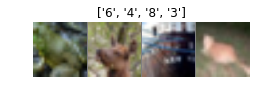

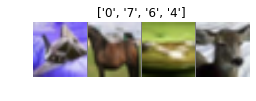

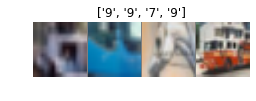

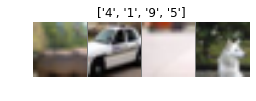

In [11]:
for i in range(4):
  show_batch_images(trainloader)

# Creating ResNet

In [0]:
from torchvision import models

In [13]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:03<00:00, 13381749.90it/s]


In [17]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
for param in resnet.parameters():
  param.requires_grad = False

In [0]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [18]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

In [0]:
import copy

In [27]:
loss_epoch_arr = []
max_epochs = 1
min_loss = 100

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  
  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    
    outputs = resnet(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    
    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(resnet.state_dict())
      print('Min Loss : %0.2f' % min_loss)
    
    if i % 100 == 0:
      print('Iteration : %d/%d, Loss : %0.2f' % (i, n_iters, loss.item()))
      
    del inputs, labels, outputs
    torch.cuda.empty_cache()
            
  loss_epoch_arr.append(loss.item())
  print('Epoch : %d/%d, Train accuracy : %0.2f, Test accuracy : %0.2f' % (epoch, max_epochs, evaluation(trainloader, resnet), evaluation(testloader, resnet)))
  
plt.plot(loss_epoch_arr)
plt.show()

Min Loss : 2.64
Iteration : 0/3125, Loss : 2.64
Min Loss : 2.10
Min Loss : 1.80
Min Loss : 1.52
Min Loss : 1.41
Min Loss : 1.35
Min Loss : 1.18
Min Loss : 1.13
Iteration : 100/3125, Loss : 2.18
Min Loss : 1.10
Min Loss : 1.04
Iteration : 200/3125, Loss : 1.67
Min Loss : 1.00
Min Loss : 0.71
Iteration : 300/3125, Loss : 1.98
Min Loss : 0.68
Iteration : 400/3125, Loss : 1.71
Min Loss : 0.52
Iteration : 500/3125, Loss : 1.71
Iteration : 600/3125, Loss : 0.85
Min Loss : 0.39
Iteration : 700/3125, Loss : 2.10
Iteration : 800/3125, Loss : 1.02
Iteration : 900/3125, Loss : 1.64
Iteration : 1000/3125, Loss : 2.53
Min Loss : 0.35
Iteration : 1100/3125, Loss : 1.68
Iteration : 1200/3125, Loss : 2.10
Iteration : 1300/3125, Loss : 2.10
Iteration : 1400/3125, Loss : 1.60
Iteration : 1500/3125, Loss : 0.90
Iteration : 1600/3125, Loss : 1.71
Iteration : 1700/3125, Loss : 2.03
Iteration : 1800/3125, Loss : 2.88
Iteration : 1900/3125, Loss : 2.14
Iteration : 2000/3125, Loss : 3.16
Iteration : 2100/3125

KeyboardInterrupt: ignored

In [0]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))